<a href="https://colab.research.google.com/github/hongqin/AI-camp/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code will train a GAN on the MNIST dataset for 50 epochs. The generator will learn to create images that look like handwritten digits, and the discriminator will learn to tell the difference between real and generated images. Please note that training GANs can be computationally intensive and may take a while to run, especially for larger number of epochs. You can adjust the number of epochs based on your computational resources. Also, remember to enable GPU in your Colab notebook for faster training.

Please note that this is a basic example of a GAN. There are many ways to improve and optimize this code, such as using different architectures for the generator and discriminator, using different loss functions, or using different training strategies. This code is meant to serve as a starting point for your exploration of GANs. Happy coding! 😊

Epoch = 0


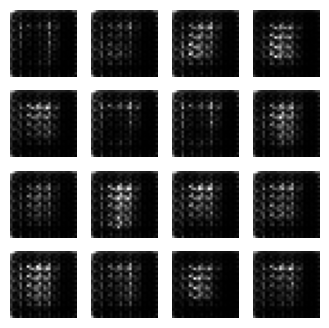

Epoch = 1


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Load the MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# Reshape and normalize the images
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize images to [-1, 1]

BUFFER_SIZE = 60000  # Buffer size for shuffling the dataset
BATCH_SIZE = 256  # Batch size for training

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Function to create the generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))  # Reshape to a 7x7x256 tensor
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # Final output is a 28x28x1 image

    return model

# Function to create the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # Output a single value for real/fake classification

    return model

## revised code below


# Define loss function for the discriminator and generator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers for both models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training step function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])  # Generate noise for generator

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Training function
def train(dataset, epochs, start_epoch=0):
    seed = tf.random.normal([16, 100])  # Fixed seed for consistent image generation
    for epoch in range(start_epoch, start_epoch + epochs):
        print("Epoch =", epoch)
        for image_batch in dataset:
            train_step(image_batch)
        generate_and_save_images(generator, epoch + 1, seed)

# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Dimension check (for debugging)
test_noise = tf.random.normal([1, 100])
test_generated_image = generator(test_noise, training=False)
assert test_generated_image.shape == (1, 28, 28, 1), "Dimension mismatch between generator output and discriminator input."

# Train the GAN
train(train_dataset, epochs=3)  # Train for 3 epochs


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


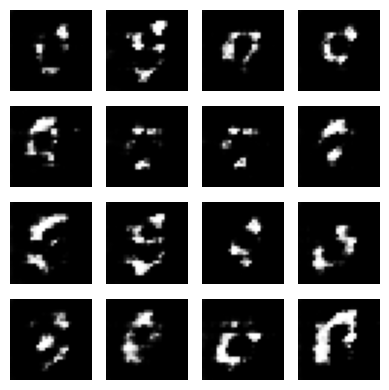

In [4]:
# Save the model
generator.save('generator_model_at_3_epochs.h5')
discriminator.save('discriminator_model_at_3_epochs.h5')


# Display images generated by the trained model
def display_generator_results(model, num_images=16, dim=(4, 4), figsize=(4, 4)):
    noise = tf.random.normal([num_images, 100])
    generated_images = model(noise, training=False)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display images
display_generator_results(generator)

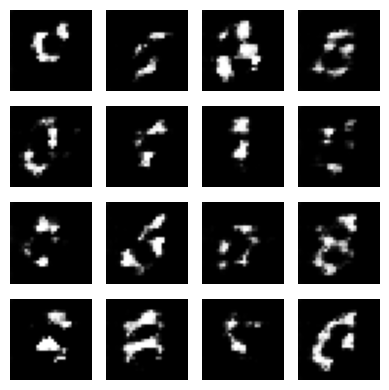

In [3]:


# Display images generated by the trained model
display_generator_results(generator)

In [ ]:


# Train the GAN
def train(dataset, epochs):
    noise = tf.random.normal([16, 100])
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, noise)

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, noise)

# Create the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Train the GAN
train(train_dataset, epochs=50)